In [2]:
import sys
sys.path.insert(0, '/Users/kedzie/Documents/Berkeley/notebooks/utilities')

import pdb
import pandas as pd
import numpy as np
import scipy
from matplotlib import rcParams as rc
rc['mathtext.default'] = 'regular'
import matplotlib.pyplot as plt
from collections.abc import Iterable
from utility_functions.utils import *
rc['font.size'] = 14

In [3]:
def baselinecorr(data, mz, end1, start2):
    #data is the DEMS mass spec dataframe, mz is the mass spec number you're interested in, ...
    # end1 is the end of initial ocv (in s), start2 is the start of baseline ocv after cycling (min)
    #find where the ocv ends by comparing eclab times with labview times

    
    index = getnearpos(data['time/min'], end1/60)-1
    index2 = getnearpos(data['time/min'], start2)
    endocvtime= getnearpos(data['time/min'], start2+50)
    plt.figure()
    plt.plot(data['time/min'], data[str(mz)], '--', label=str(mz))


    #convert mass data into dataframe variables
    d = {'time/min' : data['time/min'][3:index], str(mz) : data[str(mz)][3:index] }
    d2 =  {'time/min' : data['time/min'][index2:-30], str(mz): data[str(mz)][index2:-30] }

    df = pd.DataFrame(d); df2 = pd.DataFrame(d2)
    newdf = pd.DataFrame()
    newdf = pd.concat([df,df2])
    row,col= data.shape

    def slope(fullfile, mz, time1, time2):
        m=(fullfile[str(mz)].iloc[time2]-fullfile[str(mz)].iloc[time1])/(fullfile['time/min'].iloc[time2]-fullfile['time/min'].iloc[time1])
        return m
    
    def lin(fullfile,time,maz,cpstart,cpend):
        m= (maz.iloc[cpend]-maz.iloc[cpstart]) / (time.iloc[cpend]-time.iloc[cpstart])
        line=(m*(time-time.iloc[cpstart]) + maz.iloc[cpstart])
        return m 
    
    if mz == 2:
        m= slope( data, mz, index+2, -10 )
        correct=(m)*(data['time/min']- data['time/min'].iloc[index+2]) + data[str(mz)].iloc[index+2]-0.005
        #correct = 4.667382*10**-9*data['time/min']- 0.2536795

        
    elif mz == 32:
        m= slope( data, mz, index+2, -20 )
        correct = m * (data['time/min']- data['time/min'].iloc[index+2]) + data[str(mz)].iloc[index+2]
        
    elif mz == 44:
        m= slope( data, mz, index+2, -20)
        #print('co2: ' + str(data['time/min'].iloc[index2+50]) + 'min')
        plt.xlim(100)
        plt.ylim(0,0.15)
        correct = m*(data['time/min']- data['time/min'].iloc[index+2]) + data[str(mz)].iloc[index+2]

    plt.plot(data['time/min'], correct, '.')
    
    data[str(mz)] = data[str(mz)]-correct
    
    plt.plot(data['time/min'], data[str(mz)], '-.', label='correction')
    plt.legend()                            
    
    return (data)
#---------------------- DEMS DATA ANALYSIS ---------------------
def read_dems(file):
    df = pd.read_csv(file, sep ='\t')
    df = df.rename(columns=lambda x: x.replace('.00000', ''))
    df.rename(columns={'0':'time/min', '0.1':'temperature/C', '0.2': 'pressure/torr', '0.3':'current/mA', '0.4':'voltage/V'}, inplace= True)
    #normalize time function
    df['time/min'] = df['time/min']-df['time/min'].iloc[0]
    
    return df

def find_charge(fold):
    import os
    files = os.listdir(fold)
    import re 
    regex = 'chrg'
    look='mpt'
    #find the file names that have 'chrg' in the name and then find only the ones of those that are .mpt files
    all_chrg= [fold + f for f in files if re.search(regex, f)]
    chrg_ec = [ i for i in all_chrg if re.search(look, i)]
    chrg_ec.sort()

    #read in the mpts as dataframes and put in list ls
    ls=[]
    for i in range(len(chrg_ec)):
        ls.append(read_data(chrg_ec[i]))
        
    #normalize all the dataframes by time zero in first dataframe
    for i in range(len(ls)):
        ls[i]['time/s']= ls[i]['time/s']-ls[0]['time/s'].iloc[0]
    
    return(ls)

def convert_ion_current(demsdata):
    #slopes and intercepts in an array [oxygen, co2, hydrogen, ethylene, carbon monoxide]
    #m = [1.144462577, 1.041140556, 0.06148247455, 1.690955209, 0.7959230955]
    #m = [1.463047028, 1.255655142, 0.06148247455*1.2, 1.690955209, 0.7959230955] #9/2018
    #m = [1.1513186, 1.01161546, 0.06148247455, 1.690955209, 0.7959230955] #2/2019
    m = [1.463047028, 1.4379, 0.052035, 1.690955209, 0.7959230955] #6/29/20  1.646
    #inf_ar = 278.6590323 * demsdata['36']
    inf_ar = 286.5408 * demsdata['36']   #as of 6/2020

    vol = 499 #uL *10^-6 
    R = 62.363577 #  L*torr / (K*mol)
    temp = 293
    #covert all pressures into umoles
    demsdata['2'] = (m[2] * demsdata['2']/inf_ar ) * demsdata['pressure/torr']*vol/R/ (temp)    
    demsdata['26'] = (m[3] * demsdata['26'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (temp)
    demsdata['28'] = (m[4] * demsdata['28'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (temp)    
    demsdata['32'] = (m[0] * demsdata['32'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (temp)
    demsdata['34'] = (m[0] * demsdata['34'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (temp)
    #demsdata['36'] = (m[0] * demsdata['36'] *10**-9/inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['44'] = (m[1] * demsdata['44'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (temp)
    demsdata['45'] = (m[1] * demsdata['45'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (temp)
       
    return (demsdata) 

Text(0, 0.5, 'P (torr)')

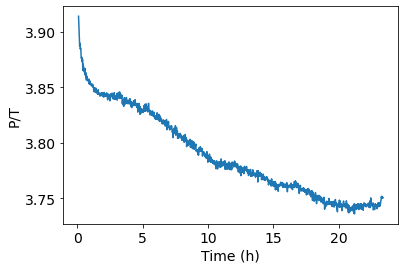

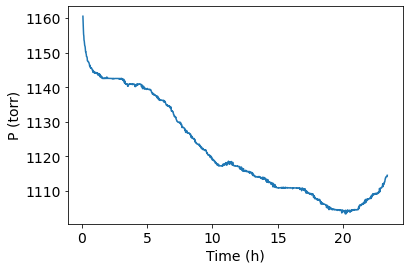

In [3]:
ocvunderar= read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201011_LiCO2_ocvunderCO2/201011_LiCO2_ocvunderCO2_rxnrate_pdecay_Ch2__2020-10-11_12.18_54.txt')

plt.plot(ocvunderar['time/s'][5:]/3600, ocvunderar['pressure/torr'][5:]/ (ocvunderar['temperature/C'][5:]+273))
plt.xlabel('Time (h)')
plt.ylabel('P/T')
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201011_LiCO2_ocvunderCO2/PoverT vs time.png')


plt.figure()
plt.plot(ocvunderar['time/s'][5:]/3600, ocvunderar['pressure/torr'][5:])
plt.xlabel('Time (h)')
plt.ylabel('P (torr)')

Text(0.5, 0, 'Time (h)')

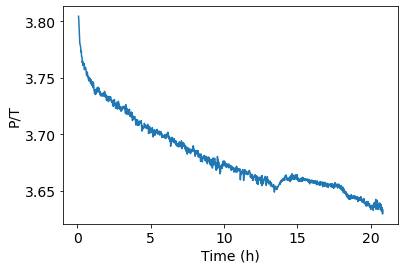

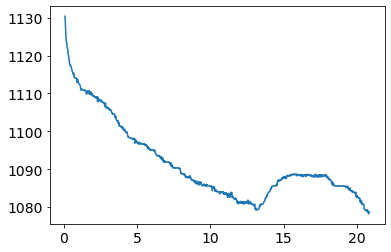

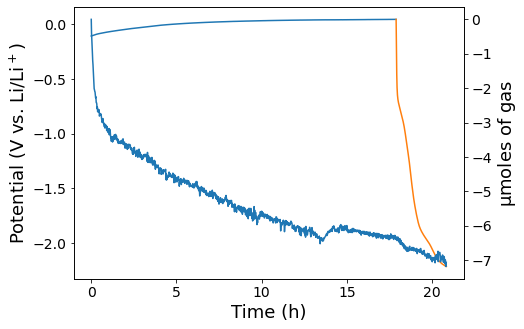

In [4]:
lfpgas = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201030_EAK_LFP_CO2_rest_discharge/201030_EAK_LFP_CO2_rest_discharge_Ch2__2020-10-30_13.36_20.txt')
lfpfolder= folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201030_EAK_LFP_CO2_rest_discharge/')

plt.plot(lfpgas['time/s'][5:]/3600, lfpgas['pressure/torr'][5:]/ (lfpgas['temperature/C'][5:]+273))
plt.xlabel('Time (h)')
plt.ylabel('P/T')

plt.figure()
plt.plot(lfpgas['time/s'][5:]/3600, lfpgas['pressure/torr'][5:])


umoles = lfpgas['pressure/torr']/760*(1792+422-80)/(lfpgas['temperature/C']+273)/0.082057
umoles = umoles - umoles[0]

fig, ax= plt.subplots( figsize=(7,5))
ax2 = ax.twinx()
ax.plot(lfpfolder[0]['time/s']/3600, lfpfolder[0]['Ewe/V'])
ax.plot(lfpfolder[1]['time/s']/3600, lfpfolder[1]['Ewe/V'])
ax.plot(lfpfolder[2]['time/s']/3600, lfpfolder[2]['Ewe/V'])
ax2.plot(lfpgas['time/s']/3600, umoles)
ax2.set_ylabel('$\mu$moles of gas', size = 18)
ax.set_ylabel('Potential (V vs. Li/Li$^+$)', size = 18)
ax.set_xlabel('Time (h)', size = 18)



203.28400000000002 -2.146708745663517
305.02599999999995 -2.776600913665874
63.88099999999999 -0.18837242819753897
125.8 -0.615515193581345


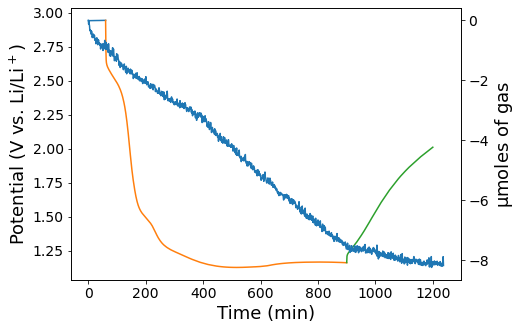

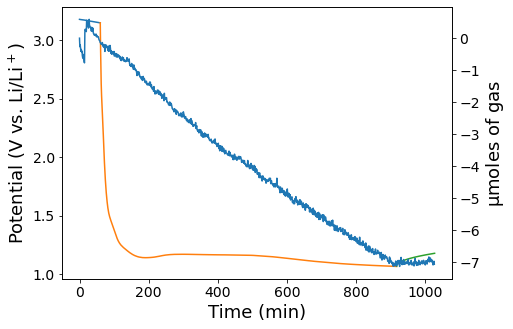

In [5]:
O2pretreat = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200924_Li-CO2cell_O2pretreatment_discharge/200924_Li-CO2cell_O2pretreatment_discharge_actual_Ch2__2020-09-25_12.22_58.txt')
O2fold = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200924_Li-CO2cell_O2pretreatment_discharge/')

umoles = O2pretreat['pressure/torr']/760*(1792+422-80)/(O2pretreat['temperature/C']+273)/0.082057
umoles = umoles - umoles[0]

fig, ax= plt.subplots( figsize=(7,5))
ax2 = ax.twinx()
ax.plot(O2fold[3]['time/s']/60, O2fold[3]['Ewe/V'])
ax.plot(O2fold[4]['time/s']/60, O2fold[4]['Ewe/V'])
ax.plot(O2fold[5]['time/s']/60, O2fold[5]['Ewe/V'])
ax2.plot(O2pretreat['time/s']/60, umoles)
ax2.set_ylabel('$\mu$moles of gas', size = 18)
ax.set_ylabel('Potential (V vs. Li/Li$^+$)', size = 18)
ax.set_xlabel('Time (min)', size = 18)
print(O2pretreat['time/s'][200]/60, umoles[200])
print(O2pretreat['time/s'][300]/60, umoles[300])



LiCO2_nopretreat = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200924_Li-CO2cell_nopretreatment_discharge/200924_Li-CO2cell_nopretreatment_discharge_Ch2__2020-09-24_19.00_16.txt')
LiCO2fold = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200924_Li-CO2cell_nopretreatment_discharge/')

umoles = LiCO2_nopretreat['pressure/torr']/760*(1792+422-80)/(LiCO2_nopretreat['temperature/C']+273)/0.082057
umoles = umoles - umoles[0]

fig, ax= plt.subplots( figsize=(7,5))
ax2 = ax.twinx()
ax.plot(LiCO2fold[3]['time/s']/60, LiCO2fold[3]['Ewe/V'])
ax.plot(LiCO2fold[4]['time/s']/60, LiCO2fold[4]['Ewe/V'])
ax.plot(LiCO2fold[5]['time/s']/60, LiCO2fold[5]['Ewe/V'])
ax2.plot(LiCO2_nopretreat['time/s']/60, umoles)
ax2.set_ylabel('$\mu$moles of gas', size = 18)
ax.set_ylabel('Potential (V vs. Li/Li$^+$)', size = 18)
ax.set_xlabel('Time (min)', size = 18)

print(LiCO2_nopretreat['time/s'][61]/60, umoles[61])
print(LiCO2_nopretreat['time/s'][120]/60, umoles[120])

(-18.0, 0.0)

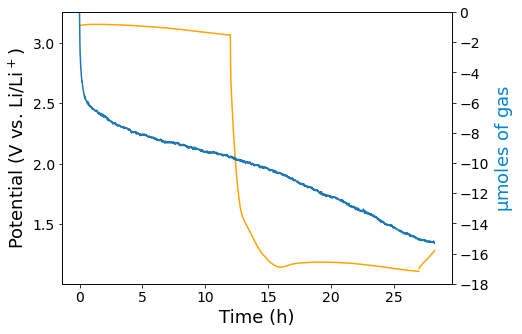

In [6]:

LiCO2_cell1 = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201119_LiCO2_ocv_discharge_dems_cell1/201119_LiCO2_ocv_discharge_dems_cell1_Ch1__2020-11-19_15.02_12.txt')
LiCO2fold = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201119_LiCO2_ocv_discharge_dems_cell1/')

umoles = LiCO2_cell1['pressure/torr']/760*(1792+422-80)/(LiCO2_cell1['temperature/C']+273)/0.082057
umoles = umoles - umoles[0]

fig, ax= plt.subplots( figsize=(7,5))
ax2 = ax.twinx()
ax.plot(LiCO2fold[0]['time/s']/3600, LiCO2fold[0]['Ewe/V'], color= 'orange')
ax.plot(LiCO2fold[1]['time/s']/3600, LiCO2fold[1]['Ewe/V'], color= 'orange')
ax.plot(LiCO2fold[2]['time/s']/3600, LiCO2fold[2]['Ewe/V'], color= 'orange')
ax2.plot(LiCO2_cell1['time/s'][:-8]/3600, umoles[:-8])
ax2.set_ylabel('$\mu$moles of gas', size = 18, color= 'xkcd:cerulean')
ax.set_ylabel('Potential (V vs. Li/Li$^+$)', size = 18)
ax.set_xlabel('Time (h)', size = 18)
ax2.set_ylim(-18,0)




(-18.0, 0.0)

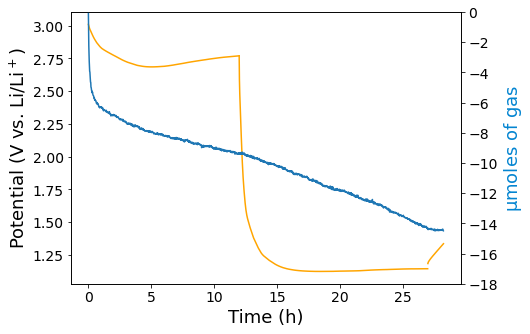

In [7]:
LiCO2_cell2 = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201119_LiCO2_ocv_discharge_dems_cell2/201119_LiCO2_ocv_discharge_dems_cell2_Ch2__2020-11-19_15.02_00.txt')
LiCO2fold2 = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201119_LiCO2_ocv_discharge_dems_cell2/')

umoles = LiCO2_cell2['pressure/torr']/760*(1792+422-80)/(LiCO2_cell2['temperature/C']+273)/0.082057
umoles = umoles - umoles[0]

fig, ax= plt.subplots( figsize=(7,5))
ax2 = ax.twinx()
ax.plot(LiCO2fold2[0]['time/s']/3600, LiCO2fold2[0]['Ewe/V'], color= 'orange')
ax.plot(LiCO2fold2[1]['time/s']/3600, LiCO2fold2[1]['Ewe/V'], color= 'orange')
ax.plot(LiCO2fold2[2]['time/s']/3600, LiCO2fold2[2]['Ewe/V'], color= 'orange')
ax2.plot(LiCO2_cell2['time/s'][:-8]/3600, umoles[:-8])
ax2.set_ylabel('$\mu$moles of gas', size = 18, color = 'xkcd:cerulean')
ax.set_ylabel('Potential (V vs. Li/Li$^+$)', size = 18)
ax.set_xlabel('Time (h)', size = 18)
ax2.set_ylim(-18,0)

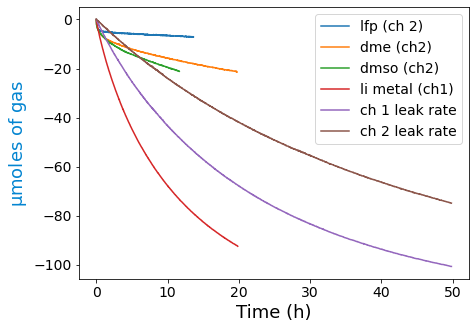

In [8]:
LFP_rest = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201120_LFP_CO2_overnightrest/201120_LFP_CO2_OCVovernight_Ch2__2020-11-20_20.23_19.txt')
umoles = LFP_rest['pressure/torr']/760*(1792+422-80)/(LFP_rest['temperature/C']+273)/0.082057
umoles = umoles - umoles[0]

DME_only = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201204_Li-CO2_control_DMEonly/201204_Li-CO2_control_DMEonly_Ch2__2020-12-04_13.53_03.txt')
umoles2 = DME_only['pressure/torr']/760*(1792+422-80)/(DME_only['temperature/C']+273)/0.082057
umoles2 = umoles2 - umoles2[0]

DMSO_only = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201204_Li-CO2_control_DMEonly/201205_Li_CO2_control_DMSOonly_co2_Ch2__2020-12-05_14.18_38.txt')
umoles3 = DMSO_only['pressure/torr']/760*(1792+422-80)/(DMSO_only['temperature/C']+273)/0.082057
umoles3 = umoles3 - umoles3[0]

Limetal_only = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201204_Li-CO2_control_Limetalonly/201204_Li-CO2_control_Limetalonly_Ch1__2020-12-04_13.53_00.txt')
umoles4 = Limetal_only['pressure/torr']/760*(1792+422-80)/(Limetal_only['temperature/C']+273)/0.082057
umoles4 = umoles4 - umoles4[0]


ch1leak = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201207_demi leak rates /ch1 leak rate_Ch1__2020-12-07_13.41_27.txt')
umoles5 = ch1leak['pressure/torr']/760*(1792+500)/(ch1leak['temperature/C']+273)/0.082057
umoles5 = umoles5 - umoles5[0]

ch2leak = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201207_demi leak rates /ch2 leak rate_Ch2__2020-12-07_13.41_30.txt')
umoles6 = ch2leak['pressure/torr']/760*(1792+500)/(ch2leak['temperature/C']+273)/0.082057
umoles6 = umoles6 - umoles6[0]


fig, ax2= plt.subplots( figsize=(7,5))
ax2.plot(LFP_rest['time/s'][:]/3600, umoles[:], label= 'lfp (ch 2)')
ax2.plot(DME_only['time/s'][:-20]/3600, umoles2[:-20], label ='dme (ch2)')
ax2.plot(DMSO_only['time/s']/3600, umoles3, label = 'dmso (ch2)')
ax2.plot(Limetal_only['time/s']/3600, umoles4, label = 'li metal (ch1)')
ax2.plot(ch1leak['time/s']/3600, umoles5, label = 'ch 1 leak rate')
ax2.plot(ch2leak['time/s']/3600, umoles6, label = 'ch 2 leak rate')




ax2.set_ylabel('$\mu$moles of gas', size = 18, color = 'xkcd:cerulean')
ax2.set_xlabel('Time (h)', size = 18)
ax2.legend()
#ax2.set_ylim(-18,0)

#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2020/Demi CO2 controls.png', bbox_inches='tight')




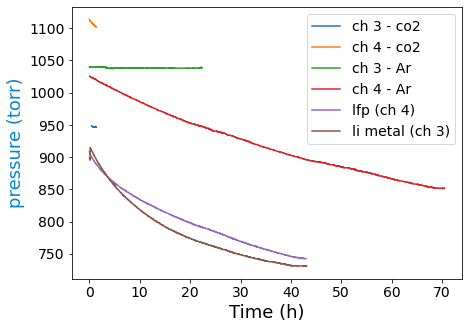

In [9]:
#delilah controls

co2_ch3 = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201216_co2_leak_controls_ch3_delilah/201216_co2_leak_controls_ch3_Ch3__2020-12-16_14.18_33.txt')
umolesd1 = co2_ch3['pressure/torr']/760*(1669+500)/(co2_ch3['temperature/C']+273)/0.082057
umolesd1 = umolesd1 - umolesd1[0]

co2_ch4 = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201216_co2_leak_controls_ch4_delilah/201216_co2_leak_controls_ch4_Ch4__2020-12-16_14.18_37.txt')
umolesd2 = co2_ch4['pressure/torr']/760*(1640+500)/(co2_ch4['temperature/C']+273)/0.082057
umolesd2 = umolesd2 - umolesd2[0]

lfp_co2 = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201216_LFP_CO2_control/201216_LFP_CO2_control_Ch4__2020-12-16_16.14_28.txt')
limetal_co2 = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201216_Limetal_CO2_control/201216_Limetal_CO2_control_Ch3__2020-12-16_16.04_51.txt')
ch4_argon = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201218_ch4leakrate_Ar_delilah/201218_ch4leakrate_Ar_Ch4__2020-12-18_12.24_34.txt')
ch3_argon = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201221_ch3leakrate_Ar/201221_ch3leakrate_Ar_Ch3__2020-12-21_12.24_02.txt')


fig, ax2= plt.subplots( figsize=(7,5))
ax2.plot(co2_ch3['time/s'][26:]/3600, co2_ch3['pressure/torr'][26:], label= 'ch 3 - co2')
ax2.plot(co2_ch4['time/s']/3600, co2_ch4['pressure/torr'], label= 'ch 4 - co2')
ax2.plot(ch3_argon['time/s']/3600, ch3_argon['pressure/torr'], label= 'ch 3 - Ar')
ax2.plot(ch4_argon['time/s'][3:]/3600, ch4_argon['pressure/torr'][3:], label= 'ch 4 - Ar')
ax2.plot(lfp_co2['time/s']/3600, lfp_co2['pressure/torr'], label= 'lfp (ch 4)')
ax2.plot(limetal_co2['time/s']/3600, limetal_co2['pressure/torr'], label= 'li metal (ch 3)')




ax2.set_ylabel('pressure (torr)', size = 18, color = 'xkcd:cerulean')
ax2.set_xlabel('Time (h)', size = 18)
ax2.legend()

#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2020/Delilah CO2 controls.png', bbox_inches='tight')




Text(0.5, 0, 'Time (h)')

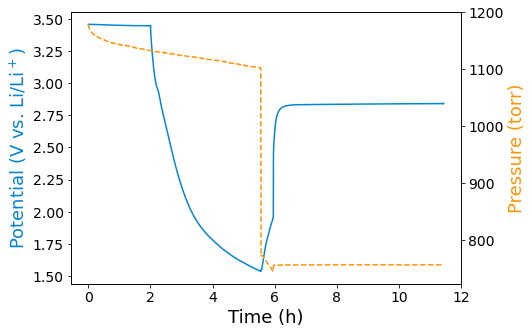

In [10]:
silvercatp = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201218_LFP_CO2_Agcat_cycle/201218_LFP_CO2_Agcat_discharge_Ch3__2020-12-18_12.24_14.txt')
silvercate = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201218_LFP_CO2_Agcat_cycle/')
umoles_ag = silvercatp['pressure/torr']/760*(1669+422-80)/(silvercatp['temperature/C']+273)/0.082057
umoles_ag = umoles_ag - umoles_ag[0]


fig, ax= plt.subplots( figsize=(7,5))
ax2 = ax.twinx()
ax.plot(silvercate[0]['time/s']/3600, silvercate[0]['Ewe/V']+3.45, color = 'xkcd:cerulean')
ax.plot(silvercate[1]['time/s']/3600, silvercate[1]['Ewe/V']+3.45, color ='xkcd:cerulean')
ax.plot(silvercate[2]['time/s']/3600, silvercate[2]['Ewe/V']+3.45, color= 'xkcd:cerulean')

ax2.plot(silvercatp['time/s']/3600, silvercatp['pressure/torr'], '--', color = 'xkcd:tangerine')
ax2.set_ylabel('Pressure (torr)', size = 18, color = 'xkcd:tangerine')
ax.set_ylabel('Potential (V vs. Li/Li$^+$)', size = 18, color = 'xkcd:cerulean')
ax.set_xlabel('Time (h)', size = 18)

#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201218_LFP_CO2_Agcat_cycle/201218_LFP_CO2_Agcat_cycle.png', bbox_inches='tight')



(1.0, 2.0)

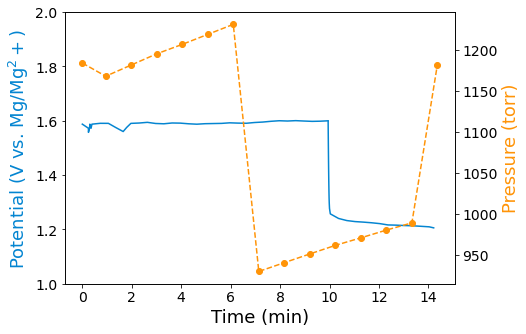

In [78]:
#mg corrosion experiments

mgotf = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201209_Mg_O2_discharge_100uA/201209_Mg_O2_discharge_Ch1__2020-12-09_16.54_10.txt')
mgotffold = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201209_Mg_O2_discharge_100uA/')
umoles_mg = mgotf['pressure/torr']/760*(1669+422-80)/(mgotf['temperature/C']+273)/0.082057
umoles_mg = umoles_mg - umoles_mg[0]



fig, ax= plt.subplots( figsize=(7,5))
ax2 = ax.twinx()
ax.plot(mgotffold[0]['time/s']/60, mgotffold[0]['Ewe/V'], color = 'xkcd:cerulean')
ax.plot(mgotffold[1]['time/s']/60, mgotffold[1]['Ewe/V'], color ='xkcd:cerulean')
ax.plot(mgotffold[2]['time/s'][:-15000]/60, mgotffold[2]['Ewe/V'][:-15000], color= 'xkcd:cerulean')

ax2.plot(mgotf['time/s']/60, mgotf['pressure/torr'], 'o--', color = 'xkcd:tangerine')
ax2.set_ylabel('Pressure (torr)', size = 18, color = 'xkcd:tangerine')
ax.set_ylabel('Potential (V vs. Mg/Mg$^2+$)', size = 18, color = 'xkcd:cerulean')
ax.set_xlabel('Time (min)', size = 18)
ax.set_ylim(1.0,2.0)


Text(0, 0.5, 'Pressure (torr)')

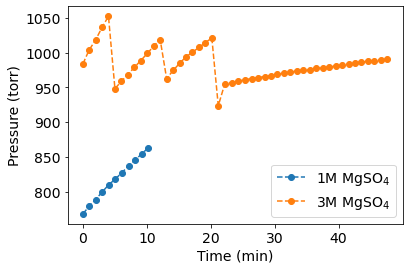

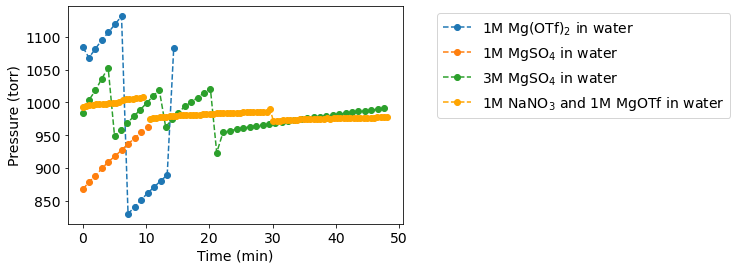

In [19]:
mgotfandno3 = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210112_Mg_Ar_h2evolution_NO3_OTf/210112_Mg_Ar_h2evolution_NO3_OTf_Ch3__2021-01-12_14.51_15.txt')
mgso4_1m = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201216_MgSO4_argon_test/201216_MgSO4_argon_test_Ch1__2020-12-16_15.03_56.txt')
mgso4_3m = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201221_3M_MgSO4_argon/201221_3M_MgSO4_argon_test_Ch1__2020-12-21_11.36_09.txt')
mgno3_ethwater = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210202_Mg(NO3)2_ethanol-h2O_Ar/210202_Mg(NO3)2_ethanol-h2O_Ar_Ch3__2021-02-02_11.12_01.txt')
mgno3_2 = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210131_Mg(NO3)2_ethanol_Ar_test/210131_Mg(NO3)2_ethanol_Ar_test_Ch3__2021-01-31_17.02_55.txt')
mgotf = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2020/201209_Mg_O2_discharge_100uA_MgOtf/201209_Mg_O2_discharge_Ch1__2020-12-09_16.54_10.txt')




plt.figure()
plt.plot(mgotf['time/s']/60, mgotf['pressure/torr']-100, 'o--', label = '1M Mg(OTf)$_2$ in water')


plt.plot(mgso4_1m['time/s']/60, mgso4_1m['pressure/torr']+100, 'o--', label = '1M MgSO$_4$ in water')
plt.plot(mgso4_3m['time/s']/60, mgso4_3m['pressure/torr'], 'o--', label = '3M MgSO$_4$ in water')

plt.plot(mgotfandno3['time/s'][:19]/60, mgotfandno3['pressure/torr'][:19], 'o--', label = '1M NaNO$_3$ and 1M MgOTf in water', color='orange')
plt.plot(mgotfandno3['time/s'][20:]/60, mgotfandno3['pressure/torr'][20:], 'o--', label = '', color = 'orange')
#plt.plot(mgno3_ethwater['time/s'][:120]/60, mgno3_ethwater['pressure/torr'][:120], 'o--', label = '1M Mg(NO$_3$)$_2$ in 50/50 EtOH/water')
#plt.plot(mgno3_2['time/s'][:40]/60, mgno3_2['pressure/torr'][:40], 'o--', label = '1M Mg(NO3)$_2$ in ethanol', color='xkcd:purple')



plt.legend(bbox_to_anchor = (2,1))
plt.xlabel('Time (min)')
plt.ylabel('Pressure (torr)')
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Presentations/group meeting figures/210101_Mgcorrosion_solventcomparison_nonitrate.png', bbox_inches='tight', transparent=True)





Text(0, 0.5, 'Pressure (torr)')

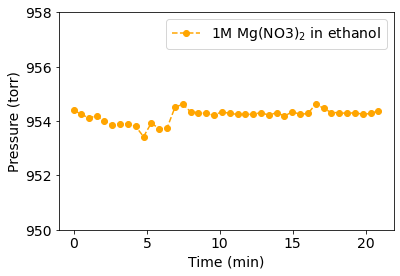

In [34]:
plt.figure()
plt.plot(mgno3_2['time/s'][:40]/60, mgno3_2['pressure/torr'][:40], 'o--', label = '1M Mg(NO3)$_2$ in ethanol', color='orange')

plt.ylim(950,958)
plt.legend()
plt.xlabel('Time (min)')
plt.ylabel('Pressure (torr)')



2.5732068411562996


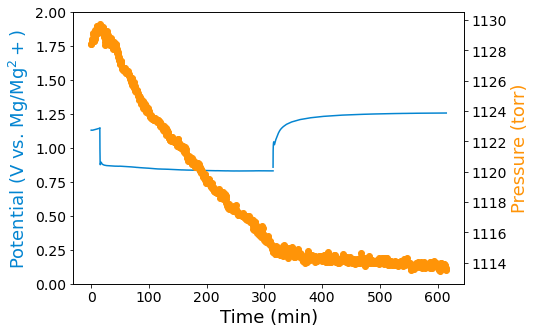

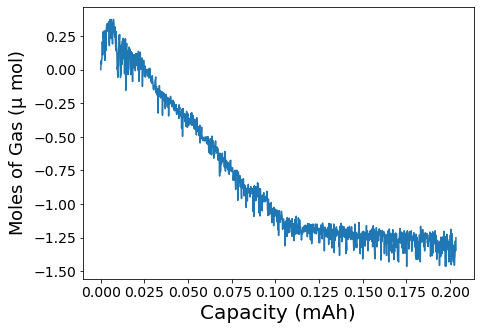

In [53]:
mgno3_2_ethanol = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210131_Mg(NO3)2_ethanol_Ar_test/210131_Mg(NO3)2_ethanol_O2_disch_Ch3__2021-01-31_17.02_55.txt')
ethanol_fold = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210131_Mg(NO3)2_ethanol_Ar_test/')

fig, ax= plt.subplots( figsize=(7,5))
ax2 = ax.twinx()
ax.plot(ethanol_fold[0]['time/s']/60, ethanol_fold[0]['Ewe/V'], color = 'xkcd:cerulean')
ax.plot(ethanol_fold[1]['time/s']/60, ethanol_fold[1]['Ewe/V'], color ='xkcd:cerulean')
ax.plot(ethanol_fold[2]['time/s'][:]/60, ethanol_fold[2]['Ewe/V'][:], color= 'xkcd:cerulean')

ax2.plot(mgno3_2_ethanol['time/s']/60, mgno3_2_ethanol['pressure/torr'], 'o--', color = 'xkcd:tangerine')
ax2.set_ylabel('Pressure (torr)', size = 18, color = 'xkcd:tangerine')
ax.set_ylabel('Potential (V vs. Mg/Mg$^2+$)', size = 18, color = 'xkcd:cerulean')
ax.set_xlabel('Time (min)', size = 18)
ax.set_ylim(0,2.0)

umoles = mgno3_2_ethanol['pressure/torr']/760*(1792+422-80)/(mgno3_2_ethanol['temperature/C']+273)/0.082057
umoles = umoles - umoles[0]

fig, ax2= plt.subplots( figsize=(7,5))
ax2.plot(mgno3_2_ethanol['time/s'][:-8]/3600*0.02, umoles[:-8])

ax2.set_xlabel('Capacity (mAh)', size = 20)
ax2.set_ylabel('Moles of Gas ($\mu$ mol)', size = 18)


epermol= 0.1*3.6/96485/(.25+1.2)*10**(6)
print(epermol)




3.6067782556874124


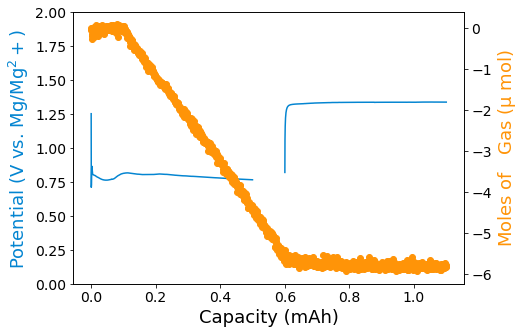

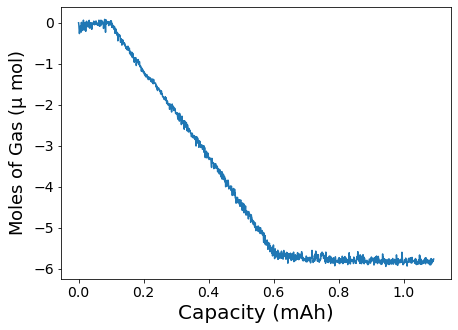

In [78]:
mgno3_ethanol = read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210203_Mg(NO3)2_EtOH_100uA/210203_Mg(NO3)2_EtOH_discharge_O2_Ch3__2021-02-03_14.33_23.txt')
ethanol_fold = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2021/210203_Mg(NO3)2_EtOH_100uA/')
umoles = mgno3_ethanol['pressure/torr']/760*(1792+422-80)/(mgno3_ethanol['temperature/C']+273)/0.082057
umoles = umoles - umoles[0]



fig, ax= plt.subplots( figsize=(7,5))
ax2 = ax.twinx()
#ax.plot(ethanol_fold[0]['time/s'], ethanol_fold[0]['Ewe/V'], color = 'xkcd:cerulean')
ax.plot(ethanol_fold[1]['Capacity/mA.h'], ethanol_fold[1]['Ewe/V'], color ='xkcd:cerulean')
ax.plot(ethanol_fold[2]['time/s'][:]/3600*.1, ethanol_fold[2]['Ewe/V'][:], color= 'xkcd:cerulean')

ax2.plot(mgno3_ethanol['time/s']/3600*0.1, umoles, 'o--', color = 'xkcd:tangerine')
ax2.set_ylabel('Moles of   Gas ($\mu$ mol)', size = 18, color = 'xkcd:tangerine')
ax.set_ylabel('Potential (V vs. Mg/Mg$^2+$)', size = 18, color = 'xkcd:cerulean')
ax.set_xlabel('Capacity (mAh)', size = 18)
ax.set_ylim(0,2.0)


fig, ax2= plt.subplots( figsize=(7,5))
ax2.plot(mgno3_ethanol['time/s'][:-8]/3600*0.1, umoles[:-8])

ax2.set_xlabel('Capacity (mAh)', size = 20)
ax2.set_ylabel('Moles of Gas ($\mu$ mol)', size = 18)


epermol= 0.58*3.6/96485/(6)*10**(6)
print(epermol)



(0.0, 3.0)

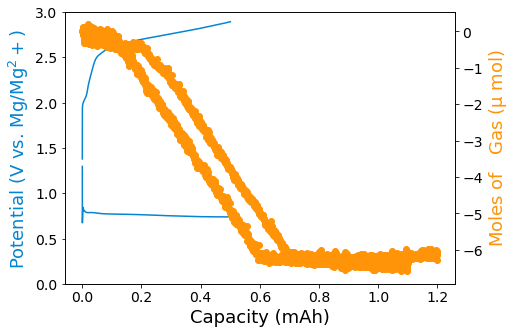